In [27]:
import numpy as np
import matplotlib.pyplot as plt
import uproot
import awkward as ak
import os
import scipy.optimize as sc
import matplotlib as mpl
import glob
from matplotlib.path import Path
from collections import Counter
from tqdm import tqdm

In [ ]:
data_path = "/home/haue/repositories/Masters/data/singleprotons/Al/"
gam_path = "/home/haue/repositories/Masters/data/gamma/Al/falsebeta/"
#outputdir = "/figure_output/"
## Load in all files from the datapath with the suffix mlio.root
Al_files = glob.glob(os.path.join(data_path, "*mlio.root"))
gam_files = glob.glob(os.path.join(gam_path, "*mlio.root"))


gates to check :
peaks = "322,342,1;"   // interval of 20 keV bagground from 302,322 & 342,362
peaks = "440,456,1;"   // interval of 16 keV bagground from 424,440 & 456,472 --- try with larger 
peaks = "720,750,1;"   // interval of 30 keV bagground from 690,720 & 750,780 // no significant amount of events same below and above the peak region
peaks = "830,846,2;"   // peak due to summing of 332 keV & 511 annihilation photon, not of interest
peaks = "935,965,1;"   // interval of 12 keV bagground from 930,942 & 956,968  --- large line at 1.2
peaks = "1064,1074,3;" // interval of 10 keV bagground from 1054,1064 & 1074,1084 // no significant amount of events same below and above the peak region
peaks = "1090,1120,3;" // interval of 30 keV bagground from 1066,1101 & 1116,1131  --- visible contribution from 5 MeV ish
peaks = "1366,1396,4;" // interval of 30 keV bagground from 1336,1366 & 1396,1426 -- very good
peaks = "1584,1596,6;" // interval of 12 keV bagground from 1572,1584 & 1596,1608 -- no good
peaks = "1620,1650,5;" // interval of 22 keV bagground from 1598,1620 & 1642,1664 ---- ery good
peaks = "1710,1730,1;" // interval of 20 keV bagground from 1690,1710 & "reuse below" 
peaks = "1740,1760,1;" // interval of 20 KeV bagground from "resuse above" & 1760,1780
peaks = "1855,1900,1;" // interval of 12 keV bagground from 1868,1880 & 1892,1904  ---- alpha peak is visible at 3.5 MeV 
peaks = "2480,2510,7;" // interval of 30 keV bagground from 2450,2480 & 2510,2540 2450 2530 --- not a significant amount of events
peaks = "2810,2840,1;" // interval of 30 keV bagground from 2780,2810 & 2840,2870

In [29]:
# Define gamma gates and their background regions
peak_gates = {
    "332": [(322, 342), (302, 322), (342, 362)],
    "950": [(935, 965), (905, 935), (965, 995)],
    "1113": [(1090,1120), (1060,1090), (1120,1150)],
    "1384": [(1366,1396), (1336,1366), (1396,1426)],
    "1634": [(1620,1650), (1590,1620), (1650,1680)]
    # can add more gates...
}
# Initialize storage for results
gprotons = {}
region_labels = ["gate", "lower_bg", "upper_bg"]

for gate_name, peak_ranges in peak_gates.items():
    Elist_1 = [np.array([]) for _ in peak_ranges]
    Elist_2 = [np.array([]) for _ in peak_ranges]

    for i, (low, high) in enumerate(peak_ranges):
        
        for batch in uproot.iterate(gam_files, expressions=["E"],
            cut=f"(pg1) & (Eg1>{low}) & (Eg1<{high}) & (id<4)"):
            Elist_1[i] = np.append(Elist_1[i], ak.flatten(batch.E))

        for batch in uproot.iterate(gam_files, expressions=["E"],
            cut=f"(pg2) & (Eg2>{low}) & (Eg2<{high}) & (id<4)"):
            Elist_2[i] = np.append(Elist_2[i], ak.flatten(batch.E))

    # Clean and combine
    Elist_1 = [arr[~np.isnan(arr)] for arr in Elist_1]
    Elist_2 = [arr[~np.isnan(arr)] for arr in Elist_2]
    Elist = [np.concatenate((a1, a2)) for a1, a2 in zip(Elist_1, Elist_2)]

    # Store in dictionary with semantic labels
    gprotons[gate_name] = {
        region_labels[i]: Elist[i] for i in range(len(region_labels))
    }
    print(f"Gate: {gate_name} processed succesfully!")

Gate: 332 processed succesfully!
Gate: 950 processed succesfully!
Gate: 1113 processed succesfully!
Gate: 1384 processed succesfully!
Gate: 1634 processed succesfully!


In [42]:
# Define gamma gates and their background regions
peak_gates = {
    "1887": [(1855,1900), (1810, 1855), (1900, 1945)]
    # can add more gates...
}

# Initialize storage for results
galphas = {}
region_labels = ["gate", "lower_bg", "upper_bg"]

for gate_name, peak_ranges in peak_gates.items():
    Elist_1 = [np.array([]) for _ in peak_ranges]
    Elist_2 = [np.array([]) for _ in peak_ranges]

    for i, (low, high) in enumerate(peak_ranges):
        
        for batch in uproot.iterate(gam_files, expressions=["Ea"],
            cut=f"(pg1) & (Eg1>{low}) & (Eg1<{high}) & (id<4)"):
            Elist_1[i] = np.append(Elist_1[i], ak.flatten(batch.Ea))

        for batch in uproot.iterate(gam_files, expressions=["Ea"],
            cut=f"(pg2) & (Eg2>{low}) & (Eg2<{high}) & (id<4)"):
            Elist_2[i] = np.append(Elist_2[i], ak.flatten(batch.Ea))

    # Clean and combine
    Elist_1 = [arr[~np.isnan(arr)] for arr in Elist_1]
    Elist_2 = [arr[~np.isnan(arr)] for arr in Elist_2]
    Elist = [np.concatenate((a1, a2)) for a1, a2 in zip(Elist_1, Elist_2)]

    # Store in dictionary with semantic labels
    galphas[gate_name] = {
        region_labels[i]: Elist[i] for i in range(len(region_labels))
    }
    print(f"Gate: {gate_name} processed succesfully!")

Gate: 1887 processed succesfully!


In [56]:
import numpy as np
import matplotlib.pyplot as plt

def plot_energy_hists(
    energies_list,          # list of arrays of energies (in eV)
    colors=None,            # list of colors matching energies_list
    labels=None,            # list of labels matching energies_list
    bin_width=0.01,         # bin width in MeV
    title="Energy Histogram",
    xlabel="Energy (MeV)",
    ylabel="default",
    xlim=(0.25, 8.5),
    fig_ax=None             # optionally pass existing (fig, ax)
):
    """
    Plot one or more energy histograms on the same figure with consistent formatting.

    Parameters:
    - energies_list: list of np.arrays, each containing energies (in eV)
    - colors: list of color strings (same length as energies_list), default black if None
    - labels: list of labels (same length as energies_list), default None (no legend)
    - bin_width: float, bin width in MeV
    - title, xlabel, ylabel: strings for the plot
    - xlim: tuple, x-axis limits
    - fig_ax: tuple (fig, ax) if you want to add to existing plot, else None to create new

    Returns:
    - fig, ax: matplotlib figure and axis objects
    """
    bins = np.arange(0, 9 + bin_width, bin_width)
    
    if fig_ax is None:
        fig, ax = plt.subplots(figsize=(16, 7))
    else:
        fig, ax = fig_ax
    
    if colors is None:
        colors = ['k'] * len(energies_list)
    if labels is None:
        labels = [None] * len(energies_list)
    
    for energies, color, label in zip(energies_list, colors, labels):
        ax.hist(np.array(energies) / 1e3, bins=bins, histtype='step',
                edgecolor=color, color='white', lw=1, label=label)
    
    ax.set_yscale('log')
    ax.set_xticks(np.arange(0, 8.5, 0.25), minor=True)
    ax.set_xticks(np.arange(0, 8.5, 1))
    ax.set_xlim(*xlim)
    ax.set_xlabel(xlabel, fontsize=16)
    ax.set_title(title, fontsize=16)
    plt.tick_params(axis='y', which='major', direction='in', length=5, width=1, labelsize=14)
    plt.tick_params(axis='y', which='minor', direction='in', length=3, width=1)
    plt.tick_params(axis='x', which='major', direction='in', length=5, width=1, labelsize=14)
    plt.tick_params(axis='x', which='minor', direction='in', length=3, width=1)
    
    if ylabel=="default":
        ax.set_ylabel(f"Counts / {int(bin_width*1000)} keV", fontsize=16)
    else:
        ax.set_ylabel(ylabel, fontsize=16)

    
    if any(labels):
        ax.legend()
    
    return fig, ax


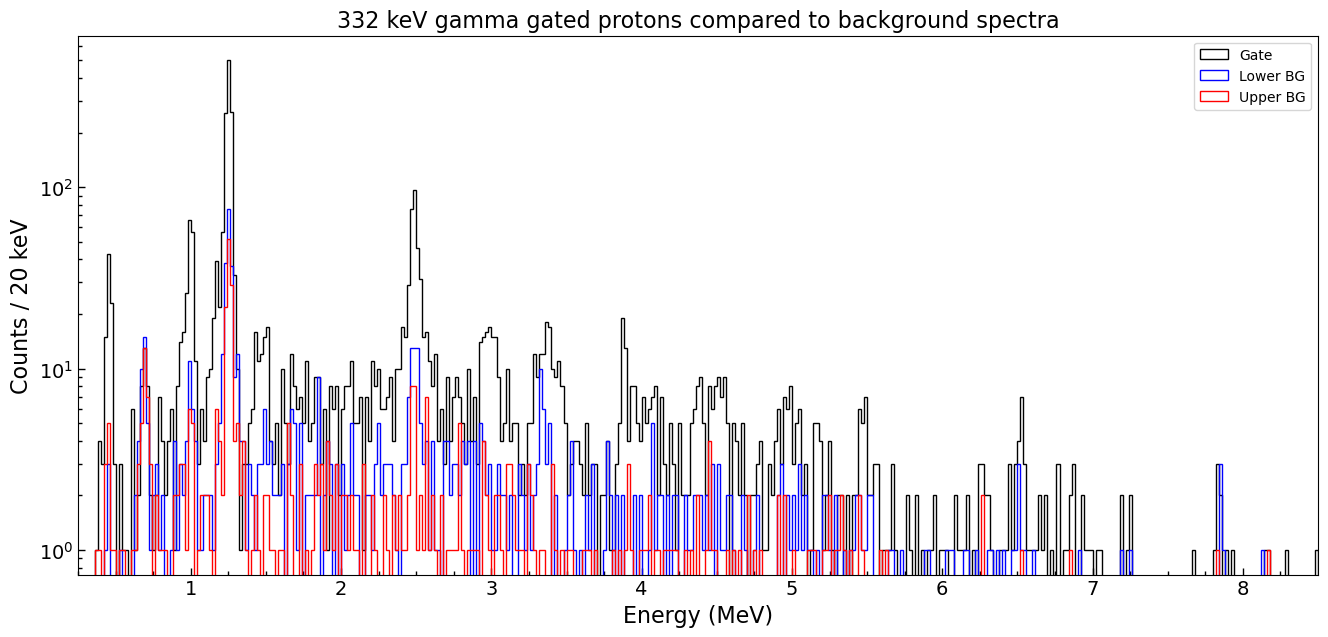

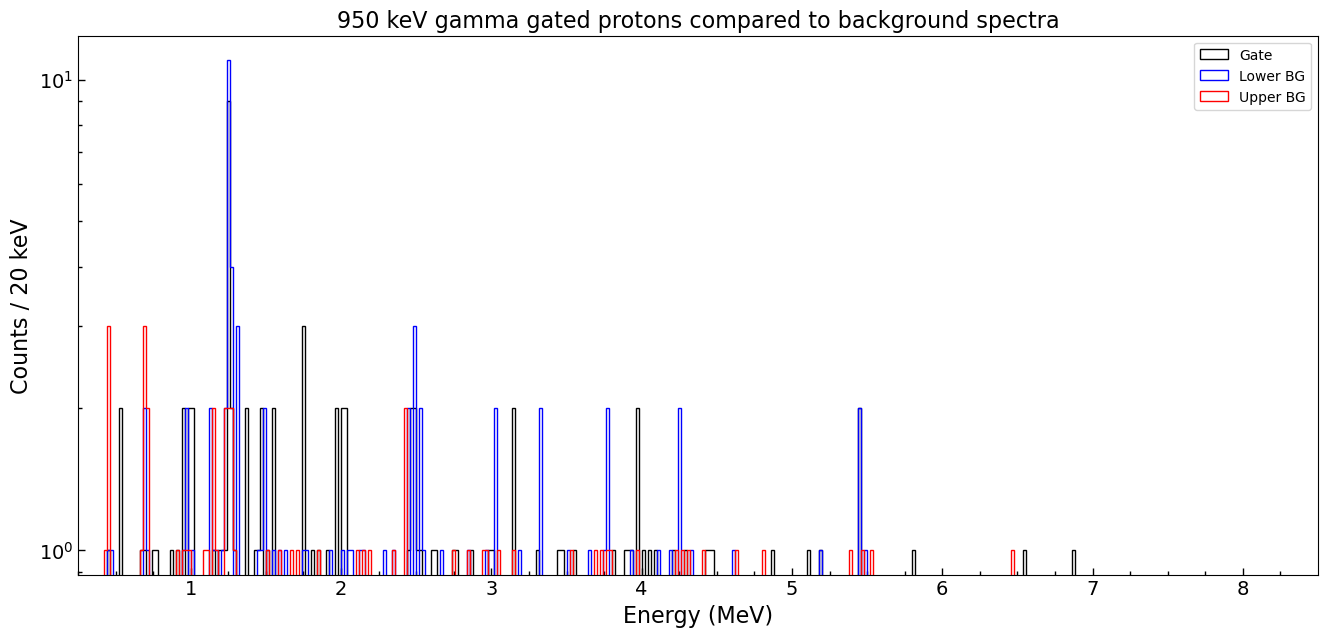

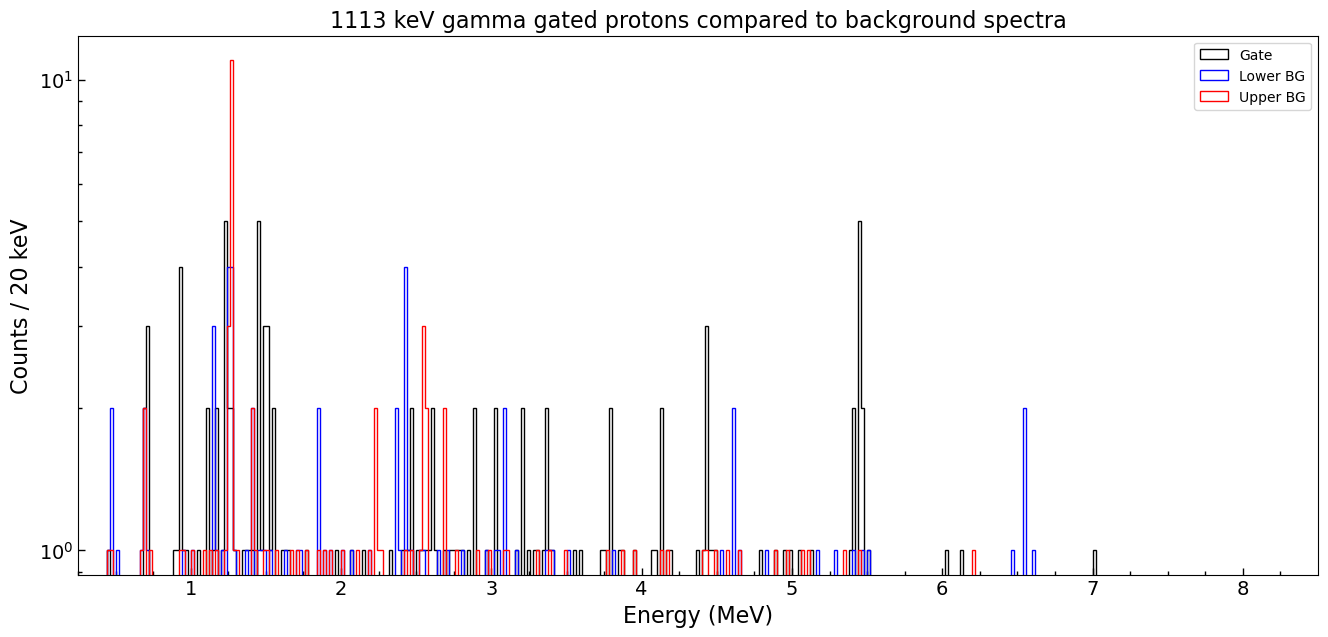

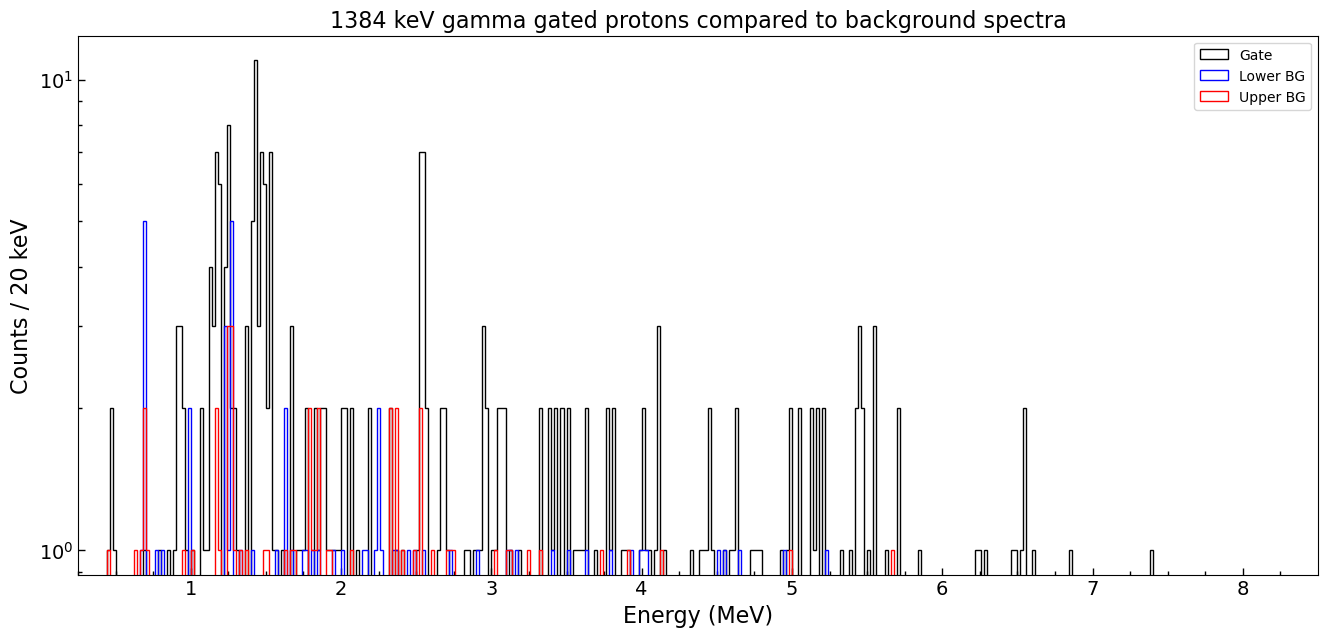

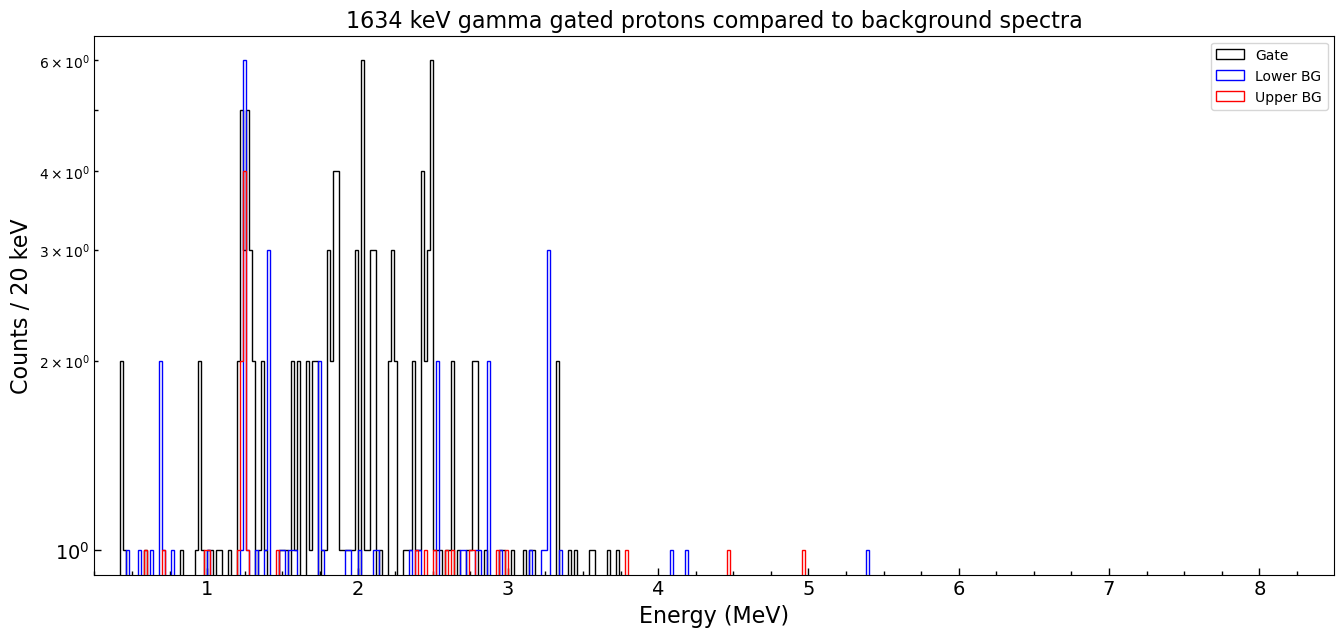

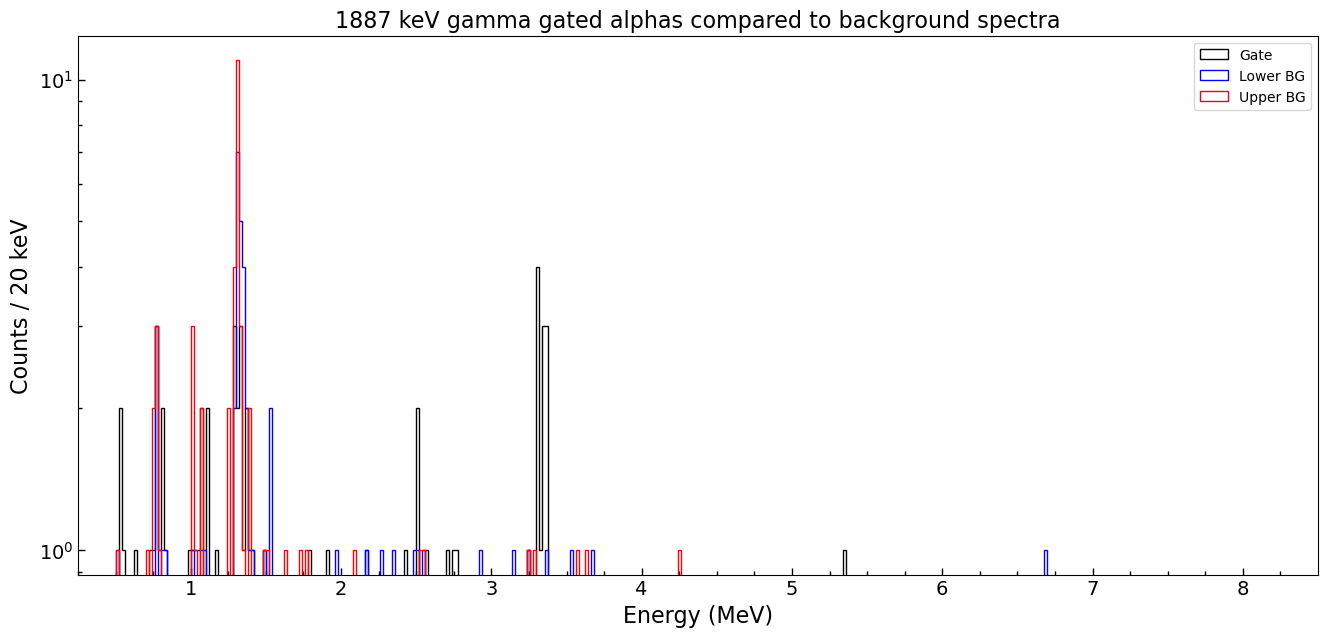

In [58]:
gates = [332, 950, 1113, 1384, 1634]
binwidth = 0.02
for g in gates:
    
    fig, ax = plot_energy_hists(
        energies_list=[gprotons[f"{g}"]["gate"], gprotons[f"{g}"]["lower_bg"], gprotons[f"{g}"]["upper_bg"]],
        colors=['k', 'b', 'r'],
        labels=['Gate', 'Lower BG', 'Upper BG'],
        bin_width=binwidth,
        title=f"{g} keV gamma gated protons compared to background spectra",
    )
    plt.show()

a = 1887
fig, ax = plot_energy_hists(
    energies_list=[galphas[f"{a}"]["gate"], galphas[f"{a}"]["lower_bg"], galphas[f"{a}"]["upper_bg"]],
    colors=['k', 'b', 'r'],
    labels=['Gate', 'Lower BG', 'Upper BG'],
    bin_width=binwidth,
    title=f"{a} keV gamma gated alphas compared to background spectra",
)
plt.show()